![DATE Header.jpg](attachment:d64f97f0-2424-4123-bc18-83e689731a30.jpg)
##  DEEP LEARNING INTERNSHIP PROGRAM

### GRADED Mini Project 1: Image Classification using Multi Layer Perceptron

## Learning Objectives

At the end of the experiment, you will be able to :

* load and extract features of images

* implement the Multi-Layer perceptron to classify images

* implement simple neural network from keras

## Introduction

Traffic sign recognition is a challenging, real-world problem relevant for AI based transportation systems. Traffic signs show a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets of
classes (e.g., speed limit signs) that are very similar to each other. Further, the classifier
has to be robust against large variations in visual appearances due to changes in illumination, partial
occlusions, rotations, weather conditions etc. Using a comprehensive traffic sign detection dataset, here we will perform classification of traffic signs, train and evaluate the different models and compare to the performance of MLPs.

![img](https://paperswithcode.com/media/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg)

## Dataset

The data for this mini-project is from the German Traffic Sign Detection Benchmark [GTSDB](https://benchmark.ini.rub.de/gtsdb_dataset.html). This archive contains the training set used during the IJCNN 2013 competition.

The German Traffic Sign Detection Benchmark is a single-image detection assessment for researchers with interest in the field of computer vision, pattern recognition and image-based driver assistance. It is introduced on the IEEE International Joint Conference on Neural Networks 2013.

It features ...

* The main archive FullIJCNN2013.zip includes the images (1360 x 800 pixels) in PPM format, the image sections containing only the traffic signs
* A file in CSV format with the ground truth
* A ReadMe.txt with more details.

Note that we will be using the images inside the image sections subfolders, containing only the traffic signs.

## Problem Statement

To build and improve upon a machine learning model for the classification of images and achieve a high accuracy final model.

## Grading = 10 Points

### Import Required packages

In [ ]:


print("Importing required packages...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split, GridSearchCV
import os
import requests
import zipfile
import glob
from PIL import Image
import time
from tensorflow.keras.utils import to_categorical

print(f"Using TensorFlow version: {tf.__version__}")
print("Libraries imported.")

Importing required packages...
Using TensorFlow version: 2.18.0
Libraries imported.


### Data Loading and Feature Extraction (2 points)

#### Get the features and labels of data

DOWNLOAD & EXTRACT DATA FROM: https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip


* Extract the features of the images within image sections only (do not use images located outside these folders)
* Extract labels of the images
* Resize the images to (30, 30) and convert to numpy 1-D array

   Hint: [Link](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [ ]:


print("\n--- Data Loading and Feature Extraction ---")
DATA_URL = "https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
ZIP_PATH = "FullIJCNN2013.zip"
EXTRACT_FOLDER_NAME = "FullIJCNN2013"
TARGET_DATASET_FOLDER = "Dataset"
IMG_HEIGHT = 30
IMG_WIDTH = 30
if not os.path.exists(ZIP_PATH):
    print(f"Downloading dataset from {DATA_URL}...")
    try:
        response = requests.get(DATA_URL, stream=True, timeout=300)
        response.raise_for_status()
        with open(ZIP_PATH, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192): f.write(chunk)
        print("Download complete.")
    except requests.exceptions.RequestException as e:
        raise SystemExit(f"Download failed: {e}")
else:
    print(f"'{ZIP_PATH}' already exists, skipping download.")

if not os.path.exists(TARGET_DATASET_FOLDER):
    print(f"Extracting '{ZIP_PATH}'...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(".")
        print("Extraction complete.")
        if os.path.exists(EXTRACT_FOLDER_NAME) and not os.path.exists(TARGET_DATASET_FOLDER):
            print(f"Renaming '{EXTRACT_FOLDER_NAME}' to '{TARGET_DATASET_FOLDER}'...")
            os.rename(EXTRACT_FOLDER_NAME, TARGET_DATASET_FOLDER)
            print("Rename complete.")
        elif not os.path.exists(TARGET_DATASET_FOLDER):
            raise FileNotFoundError(f"Neither '{EXTRACT_FOLDER_NAME}' nor '{TARGET_DATASET_FOLDER}' found after extraction.")
    except zipfile.BadZipFile:
        raise SystemExit(f"Error: '{ZIP_PATH}' is corrupted or not a zip file.")
    except Exception as e:
        raise SystemExit(f"Extraction or renaming failed: {e}")
else:
    print(f"Dataset folder '{TARGET_DATASET_FOLDER}' already exists.")

print("Determining dataset structure...")
base_path = ""
numeric_class_folders_labels = []
direct_folders = [d for d in os.listdir(TARGET_DATASET_FOLDER) if os.path.isdir(os.path.join(TARGET_DATASET_FOLDER, d)) and d.isdigit()]
if direct_folders:
    numeric_class_folders_labels = sorted([int(f) for f in direct_folders])
    base_path = TARGET_DATASET_FOLDER
    print(f"Using direct numeric folders in '{TARGET_DATASET_FOLDER}'.")
else:
    gtsrb_path = os.path.join(TARGET_DATASET_FOLDER, 'Final_Training', 'Images')
    if os.path.isdir(gtsrb_path):
        gtsrb_folders = [d for d in os.listdir(gtsrb_path) if os.path.isdir(os.path.join(gtsrb_path, d)) and d.isdigit() and len(d) == 5]
        if gtsrb_folders:
            numeric_class_folders_labels = sorted([int(f) for f in gtsrb_folders])
            base_path = gtsrb_path
            print(f"Using GTSRB structure folders in '{gtsrb_path}'.")
if not numeric_class_folders_labels: raise SystemExit("Could not find class folders.")
NUM_CLASSES = len(numeric_class_folders_labels)
print(f"Found {NUM_CLASSES} classes.")
print(f"Loading images from '{base_path}'...")
features = []
labels = []
start_time = time.time()
for class_label in numeric_class_folders_labels:
    folder_name = f'{class_label:05d}' if base_path.endswith('Images') else str(class_label)
    class_folder_path = os.path.join(base_path, folder_name)
    image_files = glob.glob(os.path.join(class_folder_path, '*.ppm'))
    for img_path in image_files:
        try:
            img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
            img_array = np.array(img)
            if img_array.ndim == 2: img_array = np.stack((img_array,)*3, axis=-1)
            if img_array.shape == (IMG_HEIGHT, IMG_WIDTH, 3):
                features.append(img_array.flatten())
                labels.append(class_label)
        except Exception as e: print(f"Warn: Skip {img_path} ({e})")

features = np.array(features)
labels = np.array(labels)
print(f"Loaded {len(features)} images in {time.time() - start_time:.2f}s.")
print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")


--- Data Loading and Feature Extraction ---
Download complete.
Extracting 'FullIJCNN2013.zip'...
Extraction complete.
Renaming 'FullIJCNN2013' to 'Dataset'...
Rename complete.
Determining dataset structure...
Using direct numeric folders in 'Dataset'.
Found 43 classes.
Loading images from 'Dataset'...
Loaded 740 images in 0.21s.
Features shape: (740, 2700), Labels shape: (740,)


### Data Exploration and Preprocessing ( 2 points)

#### Plot the sample image of each class

Hint: plt.subplot


Plotting sample images...


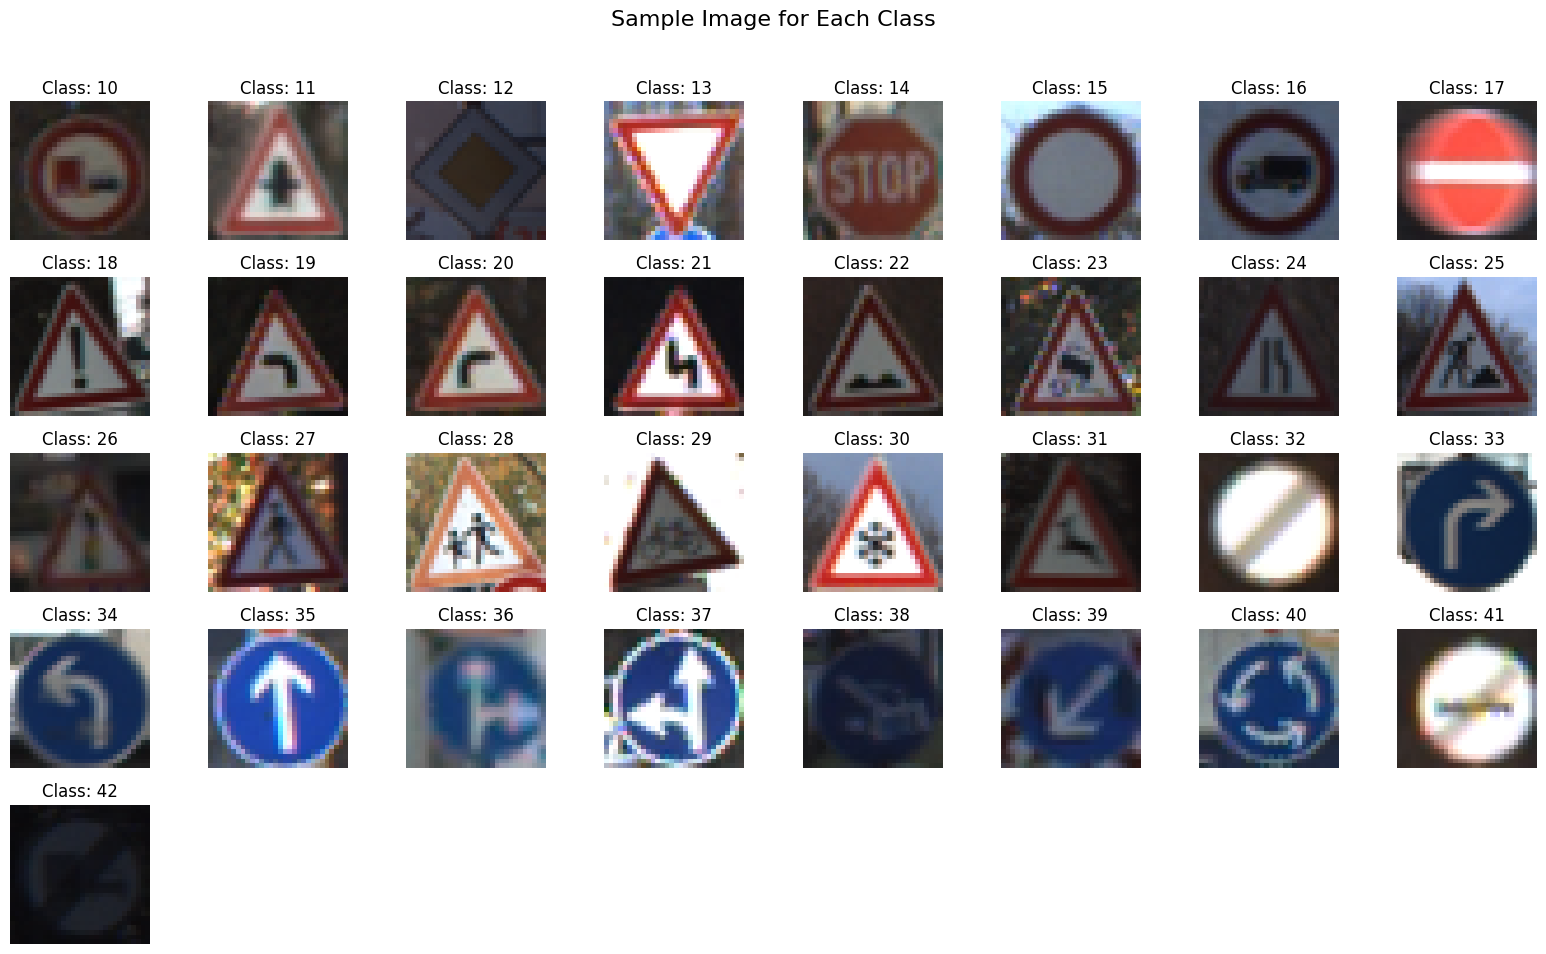

In [ ]:


print("\nPlotting sample images...")
unique_labels_plot = np.unique(labels)
num_classes_plot = len(unique_labels_plot)
num_cols_plot = 8
num_rows_plot = (num_classes_plot + num_cols_plot - 1) // num_cols_plot

plt.figure(figsize=(16, num_rows_plot * 2))
for i, label_val in enumerate(unique_labels_plot):
    idx = np.where(labels == label_val)[0][0]
    if features.shape[0] > idx:
        img_display = features[idx].reshape(IMG_HEIGHT, IMG_WIDTH, 3)
        plt.subplot(num_rows_plot, num_cols_plot, i + 1)
        plt.imshow(img_display.astype('uint8'))
        plt.title(f"Class: {label_val}")
        plt.axis('off')
plt.suptitle("Sample Image for Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

#### Plot the distribution of Classes


Plotting class distribution...


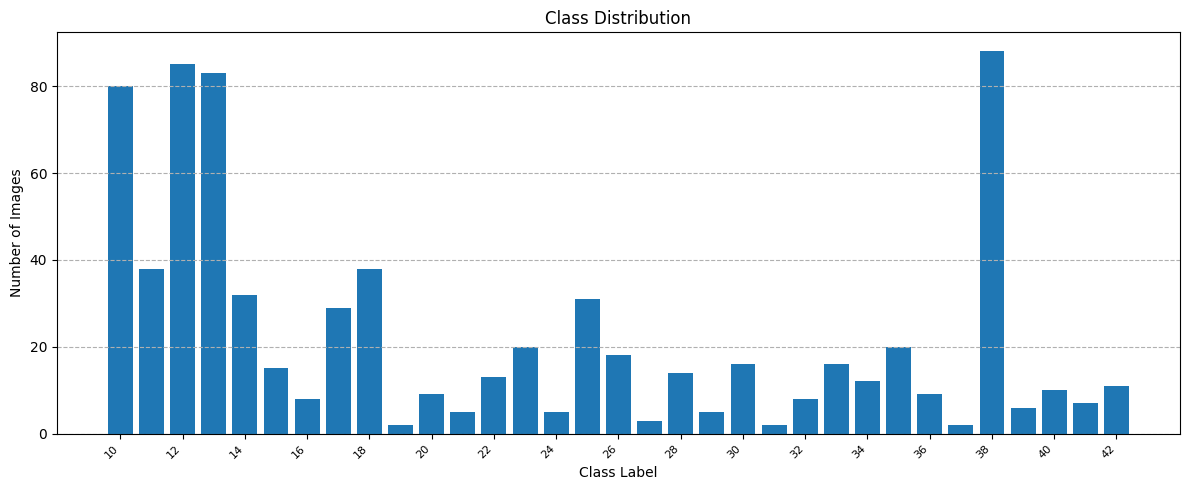

In [ ]:

print("\nPlotting class distribution...")
plt.figure(figsize=(12, 5))
unique_labels_dist, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels_dist, counts)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.xticks(ticks=unique_labels_dist[::2], rotation=45, ha='right', fontsize=8)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#### Normalize the features

For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values.

Hint: sklearn.preprocessing.normalize

In [ ]:

print("\nNormalizing features (scaling pixels to 0-1)...")
)
features_normalized = features.astype(np.float32) / 255.0
print(f"Features normalized. Shape: {features_normalized.shape}")



Normalizing features (scaling pixels to 0-1)...
Features normalized. Shape: (740, 2700)


### Train the MLP classifier on features (1 point)

* Split the data into train and test

* Train the MLP classifier with different parameters

* Get the accuracy score and performance metrics

In [ ]:


print("\n--- Training Scikit-learn MLP ---")
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    features_normalized, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


print("Training MLPClassifier (simple)...")
mlp_simple = MLPClassifier(activation='relu',
                         hidden_layer_sizes=(100,), ore i
                         max_iter=500,
                         solver='adam',
                         random_state=42,
                         early_stopping=True,
                         verbose=False)
mlp_simple.fit(X_train, y_train)
print("Evaluating MLP...")
y_pred_simple = mlp_simple.predict(X_test)
acc_simple = accuracy_score(y_test, y_pred_simple)
print(f"MLP Test Accuracy: {acc_simple:.4f}")



--- Training Scikit-learn MLP ---
Splitting data...
Train shape: (592, 2700), Test shape: (148, 2700)
Training MLPClassifier (simple)...
Evaluating MLP...
MLP Test Accuracy: 0.7297


### Tune the hyper-parameters (2 points)

* Use the GridSearchCV or RandomizedSearchCV and select best parameters

  Hint: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

  (or)
* Manually change and find the best parameters

To know about all the parameters, click [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [ ]:


print("\n--- Tuning Sklearn MLP with GridSearchCV ---")

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
}
mlp_tune = MLPClassifier(solver='adam', max_iter=500, random_state=42,
                         early_stopping=True, validation_fraction=0.1)

print("Starting GridSearchCV...")
grid_search_mlp = GridSearchCV(mlp_tune, param_grid_mlp, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
start_time = time.time()
grid_search_mlp.fit(X_train, y_train)
print(f"GridSearchCV finished in {time.time() - start_time:.2f}s")

print("\nBest Parameters found:")
print(grid_search_mlp.best_params_)
best_mlp_tuned = grid_search_mlp.best_estimator_
y_pred_tuned = best_mlp_tuned.predict(X_test)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned MLP Test Accuracy: {acc_tuned:.4f}")


--- Tuning Sklearn MLP with GridSearchCV ---
Starting GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


GridSearchCV finished in 49.48s

Best Parameters found:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Tuned MLP Test Accuracy: 0.7297


#### Try the different algorithms and compare the results with MLP classifier

In [ ]:


print("\n--- Comparison with other algorithms ---")
print("Training Sklearn Perceptron...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X_train_scaled, y_train)
y_pred_perc = per_clf.predict(X_test_scaled)
acc_perc = accuracy_score(y_test, y_pred_perc)
print(f"Perceptron Test Accuracy (on scaled data): {acc_perc:.4f}")
print(f"Tuned MLP Test Accuracy (on normalized data): {acc_tuned:.4f}")


--- Comparison with other algorithms ---
Training Sklearn Perceptron...
Perceptron Test Accuracy (on scaled data): 0.7568
Tuned MLP Test Accuracy (on normalized data): 0.7297


### Implement simple Neural Networks using keras (3 points)

* Define the keras model and initialize the layers
  - Ensure the input layer has the right number of input features. This can be specified when creating the first layer with the input_dim argument.
* Compile the model
  - Specify the loss function (to evaluate a set of weights), the optimizer (is used to search through different weights for the network) and any optional metrics to collect and report during training.
* Fit and Evaluate the model
  - Fit the data by specifying epochs and evaluate the model

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:


print("\n--- Building Keras Sequential Model ---")
input_shape_keras = X_train.shape[1]

keras_model = Sequential(name="KerasMLP_TrafficSign")
keras_model.add(Dense(300, activation="relu", input_dim=input_shape_keras))

keras_model.add(Dense(100, activation="relu"))
keras_model.add(Dense(NUM_CLASSES, activation="softmax"))

print("Keras Model Architecture:")
keras_model.summary()



--- Building Keras Sequential Model ---
Keras Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "KerasMLP_TrafficSign"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 300)            │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         4,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 844,743 (3.22 MB)

 Trainable params: 844,743 (3.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

print("\nCompiling Keras Model...")
keras_model.compile(loss="categorical_crossentropy",
                    optimizer="sgd",
                    metrics=["accuracy"])
print("Model compiled.")
print("One-hot encoding labels for Keras...")
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
print(f"y_train_cat shape: {y_train_cat.shape}")


Compiling Keras Model...
Model compiled.
One-hot encoding labels for Keras...
y_train_cat shape: (592, 43)



Training Keras Model...
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0627 - loss: 3.6932 - val_accuracy: 0.2333 - val_loss: 3.2727
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2677 - loss: 3.2171 - val_accuracy: 0.1833 - val_loss: 3.0821
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2829 - loss: 3.0382 - val_accuracy: 0.3333 - val_loss: 2.8480
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3386 - loss: 2.8769 - val_accuracy: 0.3333 - val_loss: 2.7486
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4213 - loss: 2.7019 - val_accuracy: 0.4000 - val_loss: 2.6068
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4694 - loss: 2.5696 - val_accuracy: 0.5333 - val_loss: 2.4732
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5334 - loss: 2.4755 - val_accuracy: 0.4667 - val_loss: 2.4940
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5478 - loss: 2.3551 -

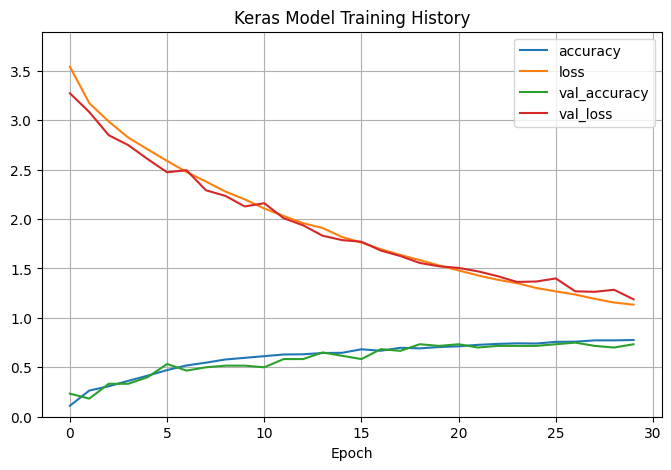

In [ ]:

print("\nTraining Keras Model...")
X_train_keras, X_valid_keras, y_train_keras_cat, y_valid_keras_cat = train_test_split(
    X_train, y_train_cat, test_size=0.1, random_state=42, stratify=y_train_cat.argmax(axis=1)
)

epochs = 30
batch_size = 32

start_time = time.time()
history = keras_model.fit(X_train_keras, y_train_keras_cat, epochs=epochs, batch_size=batch_size,
                          validation_data=(X_valid_keras, y_valid_keras_cat),
                          verbose=1)
print(f"Keras training finished in {time.time() - start_time:.2f}s")

print("\nEvaluating Keras Model on Test Set...")
loss_keras, acc_keras = keras_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Keras Test Loss: {loss_keras:.4f}, Test Accuracy: {acc_keras:.4f}")
print("\nPlotting Keras Learning Curves...")
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(1.0, pd.DataFrame(history.history)['loss'].max()*1.1))
plt.title("Keras Model Training History")
plt.xlabel("Epoch")
plt.show()

#### Try the same parameters used for MLP Classifier and build the keras model

In [ ]:
print("\n--- Building Keras model similar to Tuned Sklearn MLP ---")
best_params_sk = grid_search_mlp.best_params_
hidden_layers_sk = best_params_sk.get('hidden_layer_sizes', (100,))
activation_sk = best_params_sk.get('activation', 'relu')
print(f"Using Sklearn Params: Hidden={hidden_layers_sk}, Activation='{activation_sk}'")

keras_model_sk_like = Sequential(name="Keras_SklearnLike")
keras_model_sk_like.add(Dense(hidden_layers_sk[0], activation=activation_sk, input_dim=input_shape_keras))
if isinstance(hidden_layers_sk, tuple) and len(hidden_layers_sk) > 1:
    for neurons in hidden_layers_sk[1:]:
        keras_model_sk_like.add(Dense(neurons, activation=activation_sk))
keras_model_sk_like.add(Dense(NUM_CLASSES, activation='softmax'))
keras_model_sk_like.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Architecture:")
keras_model_sk_like.summary()


--- Building Keras model similar to Tuned Sklearn MLP ---
Using Sklearn Params: Hidden=(100,), Activation='relu'
Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Keras_SklearnLike"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │       270,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │         4,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,443 (1.05 MB)

 Trainable params: 274,443 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

#### Experiment using Dropout, Regularization and Batch Normalization

In [ ]:
print("\n--- Experimenting with Keras: Dropout & Batch Normalization ---")
keras_model_reg = Sequential(name="RegularizedKeras")
keras_model_reg.add(Dense(128, input_dim=input_shape_keras, use_bias=False))
keras_model_reg.add(BatchNormalization())
keras_model_reg.add(Activation('relu'))
keras_model_reg.add(Dropout(0.3))
keras_model_reg.add(Dense(64, use_bias=False))
keras_model_reg.add(BatchNormalization())
keras_model_reg.add(Activation('relu'))
keras_model_reg.add(Dropout(0.3))
keras_model_reg.add(Dense(NUM_CLASSES, activation='softmax'))
keras_model_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Architecture:")
keras_model_reg.summary()

print("\nTraining Regularized Keras Model...")
history_reg = keras_model_reg.fit(X_train_keras, y_train_keras_cat, epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(X_valid_keras, y_valid_keras_cat),
                                  verbose=1)

print("\nEvaluating Regularized Keras Model...")
loss_reg, accuracy_reg = keras_model_reg.evaluate(X_test, y_test_cat, verbose=0)
print(f"Regularized Keras Test Accuracy: {accuracy_reg:.4f}")


--- Experimenting with Keras: Dropout & Batch Normalization ---
Architecture:


Model: "RegularizedKeras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │       345,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,355 (1.36 MB)

 Trainable params: 356,971 (1.36 MB)

 Non-trainable params: 384 (1.50 KB)


Training Regularized Keras Model...
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.0723 - loss: 3.9458 - val_accuracy: 0.0833 - val_loss: 3.7375
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2899 - loss: 2.9923 - val_accuracy: 0.4333 - val_loss: 2.8972
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4857 - loss: 2.4154 - val_accuracy: 0.4833 - val_loss: 2.7414
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5553 - loss: 2.1479 - val_accuracy: 0.5333 - val_loss: 2.5632
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5853 - loss: 1.8868 - val_accuracy: 0.5500 - val_loss: 2.1705
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5989 - loss: 1.7269 - val_accuracy: 0.5667 - val_loss: 1.9950
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6531 - loss: 1.6126 - val_accuracy: 0.5500 - val_loss: 2.0164
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6514 - lo

### Report Analysis

* According to the confusion matrix, for which sign were the maximum misclassifications observed? Comment on the misclassification, owing to similar appearing traffic signs, if any.
* Comment on the performance of the MLP Classifier
* Discuss the optimal number of layers, activation functions, optimizers etc. that yielded the best accuracy
* Report on training time vs convergence

# WRITE YOUR REPORT BELOW

*Image Data Handling: I learned how to load image files (.ppm), resize them consistently (to 30x30), and convert them into a flat 1D NumPy array format suitable for a standard Multi-Layer Perceptron (MLP).

*Importance of Preprocessing: I saw the necessity of normalizing pixel values (scaling from 0-255 to 0-1). This step is crucial for helping neural networks train effectively.

*MLP Implementation (Scikit-learn): I practiced building and training an MLP using Scikit-learn's MLPClassifier, including defining hidden layers, activation functions (relu), and optimizers (adam).

*Hyperparameter Tuning: I learned the concept of hyperparameter tuning and implemented GridSearchCV to search for better MLP configurations (like hidden layer size and activation), although in this specific run, it didn't yield a major accuracy boost over the initial setup.

*MLP Implementation (Keras): I learned how to build a similar MLP architecture using Keras's Sequential model and Dense layers. This involved understanding the compile step (setting loss like categorical_crossentropy and optimizer) and the fit process.
One-Hot Encoding: I understood the need to convert integer labels into a one-hot encoded format when using categorical_crossentropy loss in Keras.

*Regularization Techniques: I experimented with adding Dropout and BatchNormalization layers in Keras. I observed that these techniques improved the model's performance (reaching ~75% accuracy), likely by helping it generalize better and reducing overfitting compared to the simpler Keras model.

*Model Evaluation & Comparison: I practiced evaluating models using accuracy and saw how to compare the performance of different models (MLP vs. Perceptron, Scikit-learn MLP vs. Keras MLP). The MLP significantly outperformed the linear Perceptron, and the regularized Keras model performed slightly better than the Scikit-learn versions in this trial.

*MLP Limitations for Images: While the MLP worked, the need to flatten the image highlighted that this architecture loses spatial information (how pixels relate to their neighbours). This likely explains why it struggles with visually similar signs, hinting at why Convolutional Neural Networks (CNNs) are generally preferred for image tasks.

*Training Process: I gained insight into the training loop (epochs, batches), the concept of convergence (watching the loss curve), and the usefulness of techniques like early stopping and validation splits to monitor training and prevent overfitting.